In [103]:
from calendar import c
import importlib
import os
import sys

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tf_explain
from tf_explain.core.grad_cam import GradCAM
from tensorflow import keras

sys.path.append("../../")

# INITIAL FILES CODE

In [104]:
## Initialize the names of files we are interested in and the data directory.
names = ["bank-statements", "contracts", "passport-scan", "middle-page"]
data_dir = "/data/dssg/occrp/data/processed_clean"

## Create a list of all of the image files contained in the folders of interest
pages_dir_df = pd.DataFrame(None, columns=["directory", "doc-type"])

for name in names:
    for path, currentDirectory, files in os.walk(os.path.join(data_dir, name)):
        file_path = os.path.join(path, "1.jpg")
        temp_df = pd.DataFrame([[file_path, name]], columns=["directory", "doc-type"])
        pages_dir_df = pd.concat([pages_dir_df, temp_df])

pd.options.display.max_colwidth = 200
display(pages_dir_df)

directory  \
0                                                                                                                                               /data/dssg/occrp/data/processed_clean/bank-statements/1.jpg   
0                                          /data/dssg/occrp/data/processed_clean/bank-statements/5edd7d30c8e1c45186777eb38829e7c42ce40eaf.7e03733c271ebf584b0f68e177b2cfc922dfb3e0-Jan_2014_Bank_6790/1.jpg   
0                                                                         /data/dssg/occrp/data/processed_clean/bank-statements/59239922.cf3e08af24d657da64895c8d3a3a3393ff530209-08_31_2007_038N5605/1.jpg   
0                                                                         /data/dssg/occrp/data/processed_clean/bank-statements/59240172.de3ab11b0ad8f97bd3accb8c7fff0fcc2a63a1ec-09_28_2007_03845605/1.jpg   
0                                                                         /data/dssg/occrp/data/processed_clean/bank-statements/59240040.be2b17fc382526633ec1e34ed3b3fb805722be3a-08_31_2007_038G5605/1.jpg   
..                                                                                                                                                                                                      ...   
0                                                                                        /data/dssg/occrp/data/processed_clean/middle-page/34269020.3ad6e1742e1efebb390c247d5ddf0fa6a3ad74f8-34269020/1.jpg   
0                                                                                      /data/dssg/occrp/data/processed_clean/middle-page/67342791.e38f575eea0709c0625ede743e370c65086922b1-312_17_099/1.jpg   
0                                              /data/dssg/occrp/data/processed_clean/middle-page/01fa62bfa2157b1f63c240b0d0c1bbe1dc203244.eb202ffd28c3b839a29125f05abdbf59ce07be3b-StNicholasMem_Arts/1.jpg   
0   /data/dssg/occrp/data/processed_clean/middle-page/5c01d4faffc5c3ab286ba70d9d1c135b06d937c7.a6c6f3b05ed33b080ca530f6f3b615c0c764a1c0-869_Part_Two_of_Notebook_of_original_documents_sent_to_Cayman_Na...   
0                                                    /data/dssg/occrp/data/processed_clean/middle-page/0d49aa3334ff68ce868422c14fa05c032dca8afa.9fe93d7c3f355f30e0c722d6c5996a2eabc3ea14-4012_Scan001/1.jpg   

           doc-type  
0   bank-statements  
0   bank-statements  
0   bank-statements  
0   bank-statements  
0   bank-statements  
..              ...  
0       middle-page  
0       middle-page  
0       middle-page  
0       middle-page  
0       middle-page  

[368 rows x 2 columns]

In [105]:
for name in names:
    name_pages_df = pages_dir_df[pages_dir_df["doc-type"] == name]
    print(name, name_pages_df.shape)

bank-statements (101, 2)
contracts (66, 2)
passport-scan (101, 2)
middle-page (100, 2)


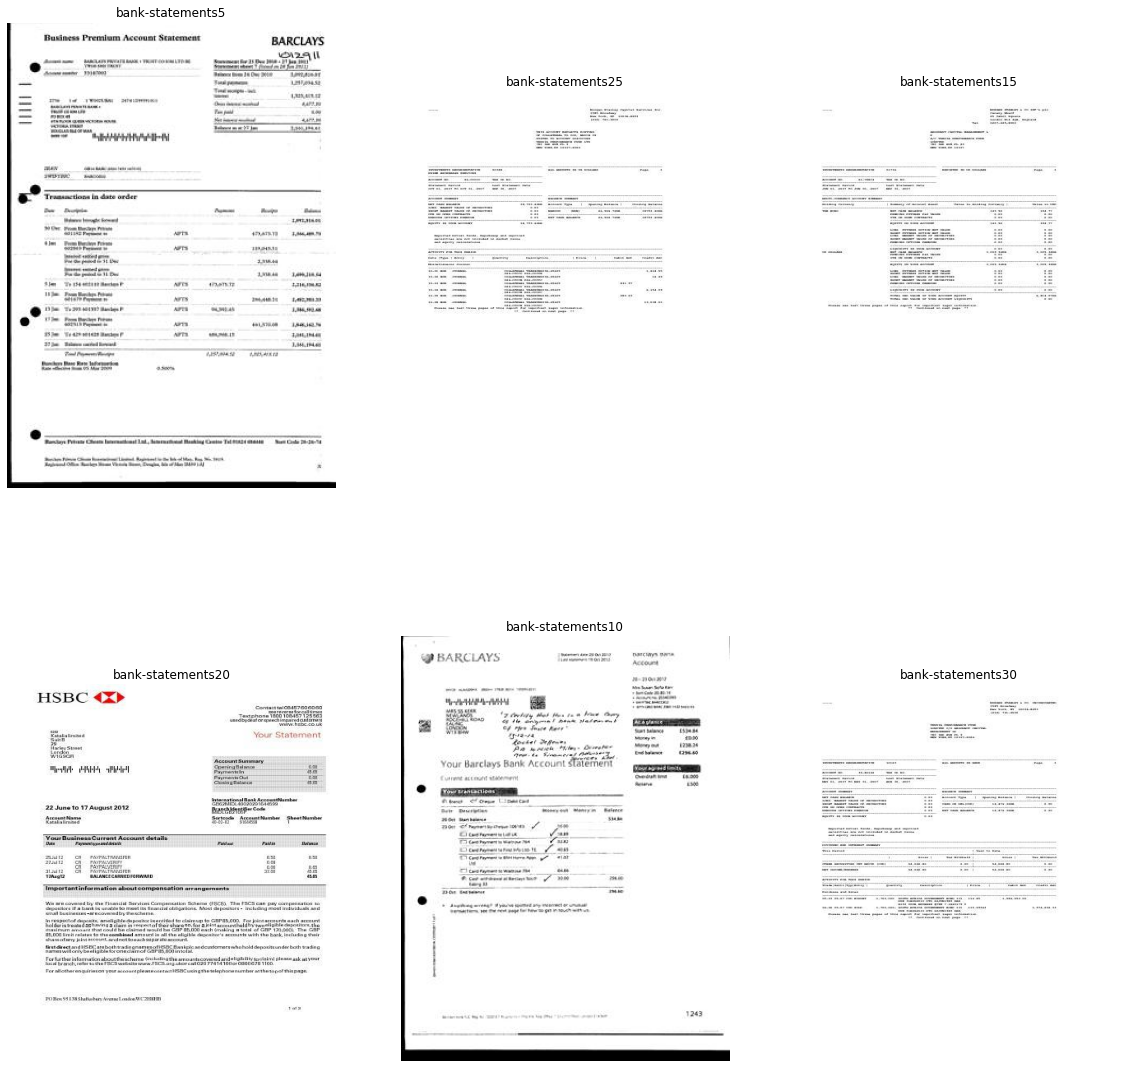

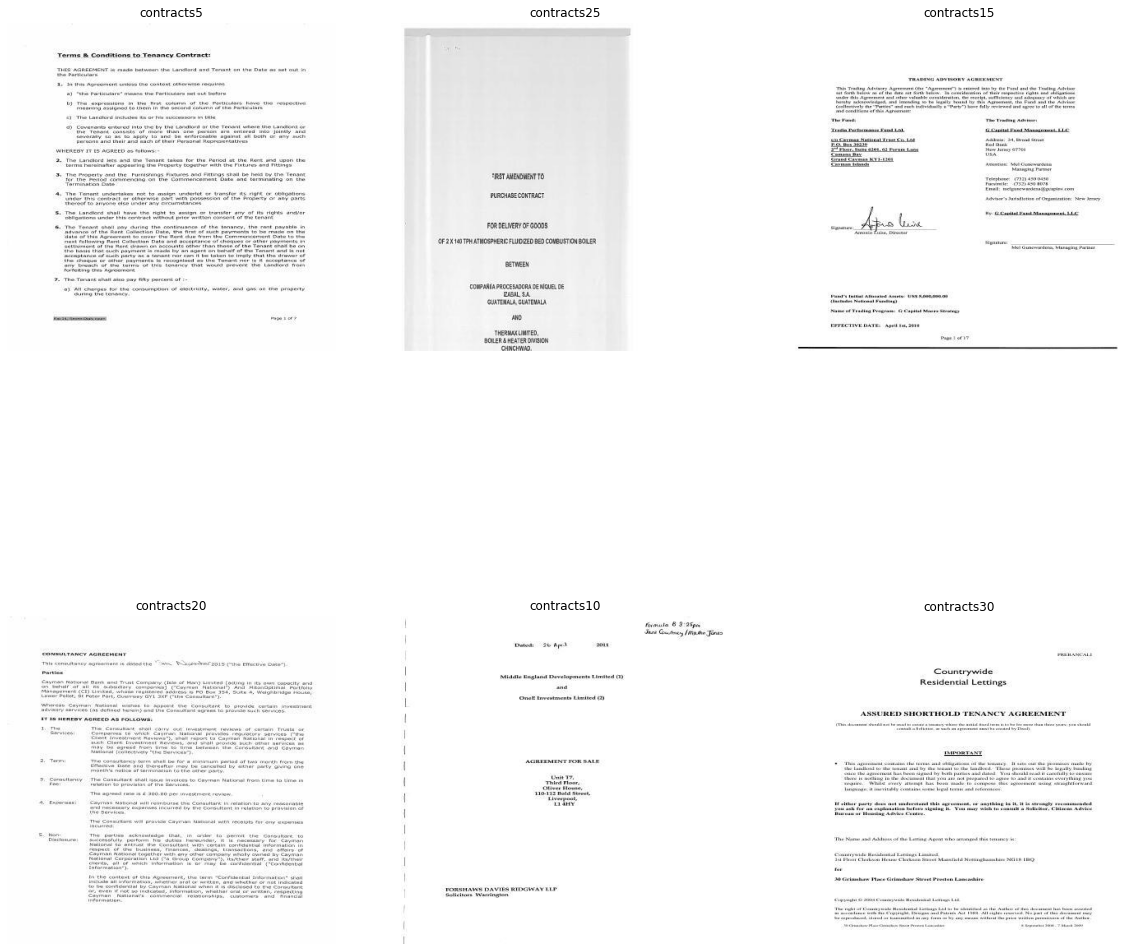

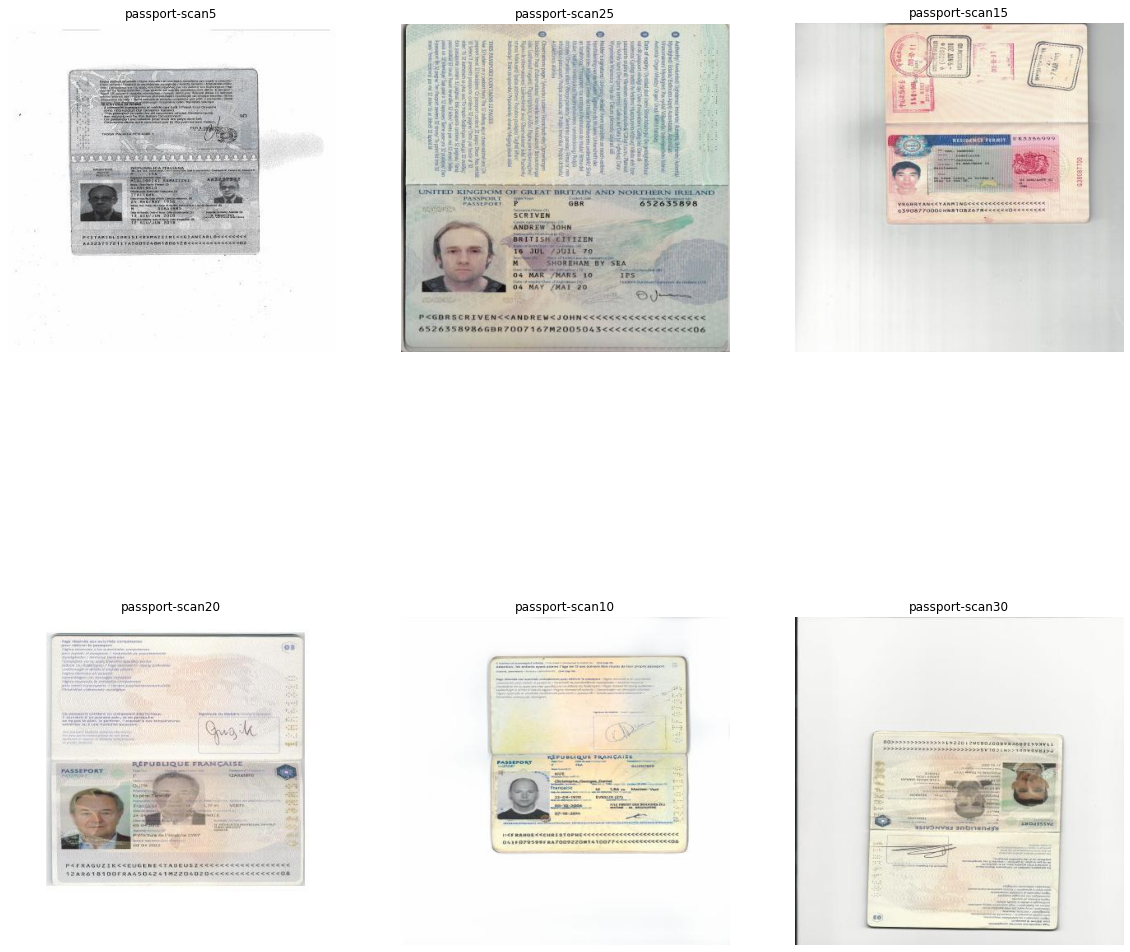

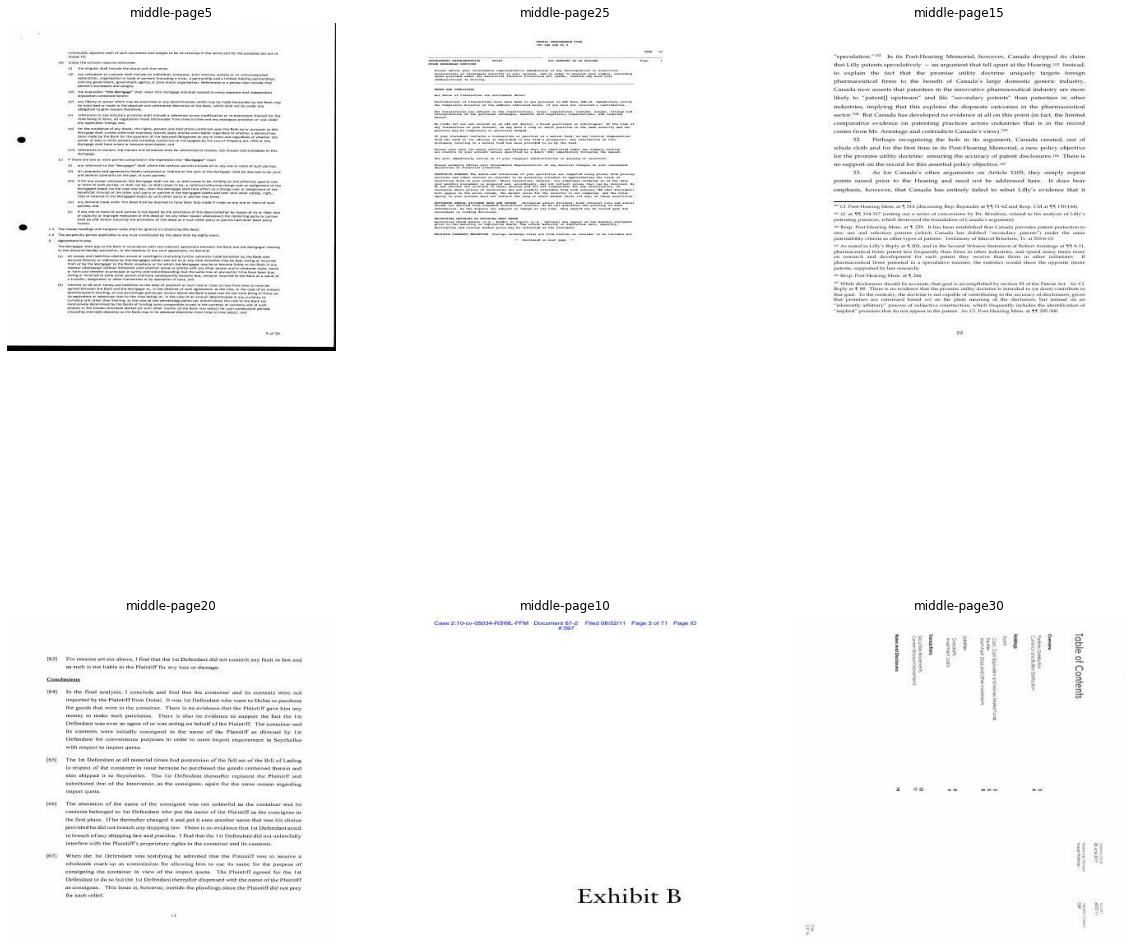

In [107]:
from tabnanny import check


checking_indexes = (5, 10, 15, 20, 25, 30)

for name in names:
    figure, axis = plt.subplots(2, 3, figsize=(10, 10))
    name_pages_df = pages_dir_df[pages_dir_df["doc-type"] == name]
    name_pages_df = name_pages_df.reset_index()
    name_pages_list = list(name_pages_df["directory"])

    for index in range(6):
        data_row = checking_indexes[index]
        img = mpimg.imread(name_pages_list[data_row])
        # cv2.imwrite(os.path.join(save_output_images_path, "train_court"+str(index)+".png"), img)

        x_ = index % 2
        y_ = index % 3
        axis[x_, y_].title.set_text(str(name + str(data_row)))
        axis[x_, y_].axis("off")
        axis[x_, y_].imshow(img)

    figure.set_figwidth(20)
    figure.set_figheight(20)
    # Combine all the operations and display
    plt.show()

In [114]:
selected_docs = pd.DataFrame(None, columns=["directory", "doc-type"])

chosen = [20, 15, 20, 15]
for index in range(4):
    name = names[index]
    name_pages_df = pages_dir_df[pages_dir_df["doc-type"] == name]
    name_pages_df = name_pages_df.reset_index()
    name_pages_list = list(name_pages_df["directory"])

    temp_df = pd.DataFrame([[name_pages_list[chosen[index]], name]], columns=["directory", "doc-type"])
    selected_docs = pd.concat([selected_docs, temp_df])

print(selected_docs)

                                                                                                                                                               directory  \
0               /data/dssg/occrp/data/processed_clean/bank-statements/7bb09b49a0aa865dd586dec4890fcc914b9c9c02.4c856c350d853c62cd67819f81320943768bbab7-document_5/1.jpg   
0                                 /data/dssg/occrp/data/processed_clean/contracts/57561186.f5a470e5fecf9a03cd784af78bceca2001135730-G_Capital_partially_executed_2/1.jpg   
0  /data/dssg/occrp/data/processed_clean/passport-scan/47f4142fba888a49a197766b7a60f1137d804e35.1e75d764717eb3bede8ad3dbb7982274f7721172-Passport_Eugu00E8ne_Guzik/1.jpg   
0            /data/dssg/occrp/data/processed_clean/middle-page/53165057.bc8512fd431c1b3c6d2c24e1d2d00775e68c1e85-Claimant_s_Reply_Post_Hearing_Brief_August_8_2016/1.jpg   

          doc-type  
0  bank-statements  
0        contracts  
0    passport-scan  
0      middle-page  


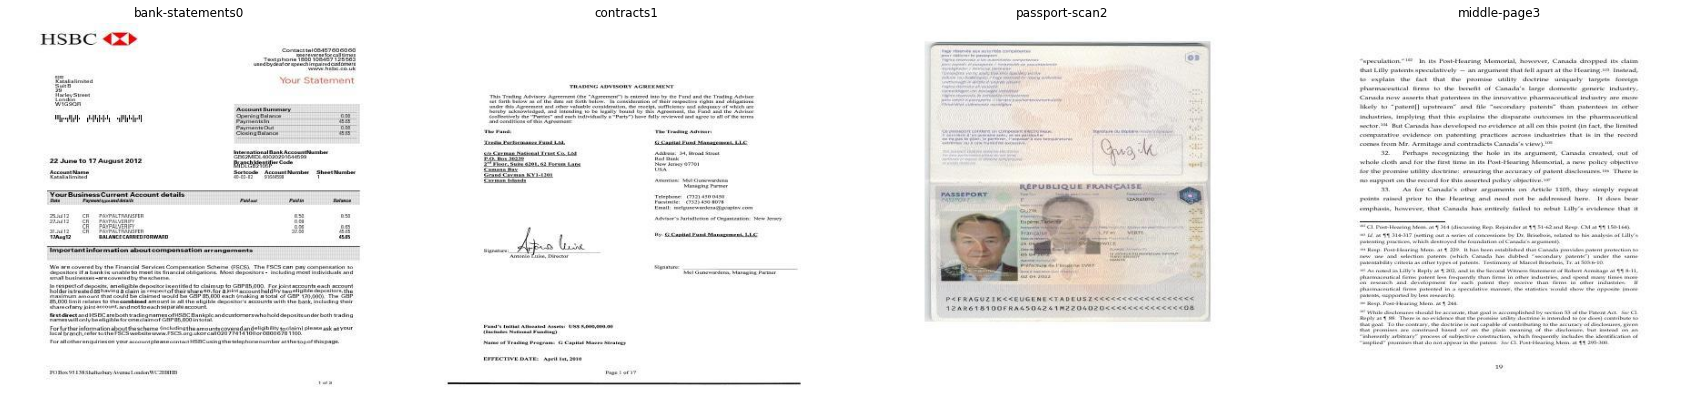

In [117]:
figure, axis = plt.subplots(1, 4, figsize=(15, 15))
selected_dir_list = list(selected_docs["directory"])
selected_name_list = list(selected_docs["doc-type"])

for index in range(4):
    data_row = index
    img = mpimg.imread(selected_dir_list[data_row])
    # cv2.imwrite(os.path.join(save_output_images_path, "train_court"+str(index)+".png"), img)

    axis[index].title.set_text(selected_name_list[index] + str(index))
    axis[index].axis("off")
    axis[index].imshow(img)

figure.set_figwidth(30)
figure.set_figheight(30)
# Combine all the operations and display
plt.show()

# IMAGE AUGMENTATION CODE:

In [137]:
# load all necessary packages
import os, sys

from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import numpy as np
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras_preprocessing.image import ImageDataGenerator

In [138]:
datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=10,
    zoom_range=0.1,
    fill_mode="nearest",
    channel_shift_range=0.9,
    height_shift_range=0.05,
    width_shift_range=0.1,
    brightness_range=[0.5, 1.5],
)

In [ ]:
## Create the dataFrame with the same repeated document:
passport_df = selected_docs[selected_docs["doc-type"] == "passport-scan"]
print(passport_df)

repeated_passport_df = pd.DataFrame(None, columns=["directory", "doc-type"])
for i in range(20):
    repeated_passport_df = pd.concat([repeated_passport_df, passport_df])

print(repeated_passport_df)

In [140]:
data_iterator = datagen.flow_from_dataframe(
    repeated_passport_df,
    x_col="directory",
    y_col="doc-type",
    classes=names,
    batch_size=1,
    save_to_dir="/home/jsanchez/dssgxdfki2022-occrp/notebooks/figures_poster/data_augmentation_figures/",
)

Found 20 validated image filenames belonging to 4 classes.


In [141]:
for x, val in zip(data_iterator, range(20)):
    pass

# TF-EXPLAIN AND FEATURE EXTRACTION VISUALIZATION

In [220]:
from tf_explain.core.grad_cam import GradCAM
from keras.engine.functional import Functional
from keras.models import Sequential

## Import model to run TF-explain on:

model = tf.keras.models.load_model(
    "/data/dssg/occrp/data/output/document_classifier/EfficientNetB4_2022_08_16-11_34_48/weights/best_model"
)

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 1792)             17673823  
                                                                 
 output_transfer_learning (D  (None, 9)                16137     
 ense)                                                           
                                                                 
Total params: 17,689,960
Trainable params: 17,564,753
Non-trainable params: 125,207
_________________________________________________________________
None


In [221]:
## Obtain the name of the last convolutional layer:
layer_names = []
layer_name: str
model_for_tfexplain: Sequential = model
for layer in model.layers:
    # check if a layer is actually a Functional object containing more layers, unpack it
    # this happens with our EfficientNet architecture
    if type(layer) == Functional:
        model_for_tfexplain = model.layers[0]
        for inside_layer in layer.layers:
            layer_names.append(inside_layer.name)
            if "conv2d_" in inside_layer.name:
                layer_name = inside_layer.name  # pick either the last conv2d one
    else:
        layer_names.append(layer.name)
        if "conv2d_" in layer.name:
            layer_name = layer.name  # pick either the last conv2d one
if layer_names.count("conv2d_last") == 1:
    layer_name = "conv2d_last"  # or the one with the name conv2d_last
if layer_names.count("top_conv") == 1:
    layer_name = "top_conv"  # or the one with the name top_conv

print(layer_name)

top_conv


In [222]:
## Create the new images of augmented documents.
datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=10,
    zoom_range=0.1,
    fill_mode="nearest",
    channel_shift_range=0.9,
    height_shift_range=0.05,
    width_shift_range=0.1,
    brightness_range=[0.5, 1.5],
)

data_iterator = datagen.flow_from_dataframe(
    selected_docs,
    x_col="directory",
    y_col="doc-type",
    classes=names,
    batch_size=1,
    save_to_dir="/home/jsanchez/dssgxdfki2022-occrp/notebooks/figures_poster/feature_extraction_figures/",
)

for x, val in zip(data_iterator, range(4)):
    pass

Found 4 validated image filenames belonging to 4 classes.


In [223]:
## Load images from the feature extraction figures folder.
names = ["bank-statements", "contracts", "passport-scan", "middle-page"]
data_dir = "/data/dssg/occrp/data/processed_clean"

## Create a list of all of the image files contained in the folders of interest
augmented_df = pd.DataFrame(None, columns=["directory", "doc-type"])
feature_extraction_dir = "/home/jsanchez/dssgxdfki2022-occrp/notebooks/figures_poster/feature_extraction_figures/"

for path, currentDirectory, files in os.walk(feature_extraction_dir):
    for file in files:
        name_index = int(file[1])
        temp_df = pd.DataFrame(
            [[os.path.join(feature_extraction_dir, file), names[name_index]]], columns=["directory", "doc-type"]
        )
        augmented_df = pd.concat([augmented_df, temp_df])

pd.options.display.max_colwidth = 200
# display(augmented_df)

In [224]:
## Reorder dataframe of augmented documents
augmented_reordered_df = pd.DataFrame(None, columns=["directory", "doc-type"])

for name in names:
    temp_df = augmented_df[augmented_df["doc-type"] == name]
    augmented_reordered_df = pd.concat([augmented_reordered_df, temp_df])


pd.options.display.max_colwidth = 200
# display(augmented_reordered_df)
print(augmented_reordered_df.shape)
n_images = augmented_reordered_df.shape[0]

(30, 2)


In [225]:
# Importing data and putting into format:
im_size = 227

augmented_reordered_dir_list = list(augmented_reordered_df["directory"])
augmented_reordered_name_list = list(augmented_reordered_df["doc-type"])
images = []
labels = []

for index in range(n_images):
    im: np.ndarray = cv2.imread(augmented_reordered_dir_list[index], 1)
    img: np.ndarray = np.array(im)  # reading image as array  # TODO isn't this already an ndarray?

    img_resized: np.ndarray = cv2.resize(img, (im_size, im_size))
    images.append(img_resized)
    labels.append(augmented_reordered_name_list[index])

images_scaled = np.array(images).astype("float32") / 255.0
print(images_scaled.shape)
print(labels)

(30, 227, 227, 3)
['bank-statements', 'bank-statements', 'bank-statements', 'bank-statements', 'bank-statements', 'bank-statements', 'bank-statements', 'bank-statements', 'bank-statements', 'contracts', 'contracts', 'contracts', 'contracts', 'contracts', 'contracts', 'contracts', 'passport-scan', 'passport-scan', 'passport-scan', 'passport-scan', 'passport-scan', 'passport-scan', 'passport-scan', 'middle-page', 'middle-page', 'middle-page', 'middle-page', 'middle-page', 'middle-page', 'middle-page']


In [226]:
print(names)

['bank-statements', 'contracts', 'passport-scan', 'middle-page']


In [229]:
# Instantiation of the explainer
explainer = GradCAM()

encoded_labels = [0, 2, 6]

for index in range(3):
    name = names[index]
    boolean_indexes = [x == name for x in augmented_reordered_name_list]
    indexes = np.where(boolean_indexes)[0]

    reduced_images_normalized = images_scaled[indexes, ...]

    reduced_images_normalized = tf.image.per_image_standardization(reduced_images_normalized)
    reduced_images_normalized = np.array(reduced_images_normalized)
    n_images = reduced_images_normalized.shape[0]

    reduced_labels = [encoded_labels[index] for i in range(n_images)]
    reduced_labels = np.array(reduced_labels)
    reduced_labels = reduced_labels.reshape(-1, 1)

    for im_index in range(n_images):
        print(reduced_images_normalized[[im_index], ...].shape)
        print(reduced_labels.shape)

        explained = explainer.explain(
            validation_data=(reduced_images_normalized[[im_index], ...], reduced_labels[[im_index]]),
            model=model_for_tfexplain,
            class_index=encoded_labels[index],
            layer_name=layer_name,
        )
        # Save output
        explainer.save(
            explained,
            output_dir=os.path.join(feature_extraction_dir, "tf_explain_figures/"),
            output_name=name + str(im_index) + ".png",
        )

(1, 227, 227, 3)
(9, 1)
(1, 227, 227, 3)
(9, 1)
(1, 227, 227, 3)
(9, 1)
(1, 227, 227, 3)
(9, 1)
(1, 227, 227, 3)
(9, 1)
(1, 227, 227, 3)
(9, 1)
(1, 227, 227, 3)
(9, 1)
(1, 227, 227, 3)
(9, 1)
(1, 227, 227, 3)
(9, 1)
(1, 227, 227, 3)
(7, 1)
(1, 227, 227, 3)
(7, 1)
(1, 227, 227, 3)
(7, 1)
(1, 227, 227, 3)
(7, 1)
(1, 227, 227, 3)
(7, 1)
(1, 227, 227, 3)
(7, 1)
(1, 227, 227, 3)
(7, 1)
(1, 227, 227, 3)
(7, 1)
(1, 227, 227, 3)
(7, 1)
(1, 227, 227, 3)
(7, 1)
(1, 227, 227, 3)
(7, 1)
(1, 227, 227, 3)
(7, 1)
(1, 227, 227, 3)
(7, 1)
(1, 227, 227, 3)
(7, 1)


# REGENERATE DENSITY THRESHOLD PLOTS:

In [186]:
from sklearn.metrics import accuracy_score
from utils.gaussian import get_classes_thresholds
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

scores_path = "/data/dssg/occrp/data/output/document_classifier/EfficientNetB4_2022_08_16-11_34_48/assessment"
scores_filename = "test_predictions.csv"
scores_df = pd.read_csv(os.path.join(scores_path, scores_filename), header=0)

print(scores_df.shape)
print(scores_df.columns)

(245, 12)
Index(['bank-statements', 'company-registry', 'contracts', 'court-documents',
       'gazettes', 'invoices', 'passport-scan', 'receipts',
       'shipping-receipts', 'true-label', 'predicted', 'path'],
      dtype='object')


In [187]:
scores_df["max-pred"] = scores_df[scores_df.columns[range(9)]].idxmax(axis=1)

In [132]:
accuracy_score(scores_df["true-label"], scores_df["max-pred"])

0.9346938775510204

In [188]:
prediction_dict = {}
for col in scores_df.columns[:-2]:
    prediction_dict[col] = scores_df[scores_df["true-label"] == col][col]
# train_prediction_dict = train_prediction_df[self.text_labels].to_dict(orient="list")
class_thresholds = get_classes_thresholds(prediction_dict, scale=1)
print(class_thresholds)
class_thresholds3 = get_classes_thresholds(prediction_dict, scale=3)
print(class_thresholds3)

{'bank-statements': 0.9731392921970343, 'company-registry': 0.8110307894458362, 'contracts': 0.7392704911543706, 'court-documents': 0.964498300659405, 'gazettes': 0.994651937341322, 'invoices': 0.6011905708432699, 'passport-scan': 0.9986913075399035, 'receipts': 0.7878274028594172, 'shipping-receipts': 0.7000638893635042, 'true-label': 0.5, 'predicted': 0.5}
{'bank-statements': 0.9194178765911031, 'company-registry': 0.5, 'contracts': 0.5, 'court-documents': 0.8934949019782149, 'gazettes': 0.9839558120239658, 'invoices': 0.5, 'passport-scan': 0.9960739226197106, 'receipts': 0.5, 'shipping-receipts': 0.5, 'true-label': 0.5, 'predicted': 0.5}


/home/thenn/.local/share/virtualenvs/dssgxdfki2022-occrp-CY4k_1kg/lib64/python3.8/site-packages/scipy/stats/_continuous_distns.py:386: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/home/thenn/.local/share/virtualenvs/dssgxdfki2022-occrp-CY4k_1kg/lib64/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/thenn/.local/share/virtualenvs/dssgxdfki2022-occrp-CY4k_1kg/lib64/python3.8/site-packages/scipy/stats/_continuous_distns.py:391: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


In [166]:
print(scores_df.columns[:-1])

Index(['bank-statements', 'company-registry', 'contracts', 'court-documents',
       'gazettes', 'invoices', 'passport-scan', 'receipts',
       'shipping-receipts', 'true-label', 'predicted', 'path'],
      dtype='object')


In [135]:
scores_df

bank-statements  company-registry  contracts  court-documents  gazettes  \
0           0.000582          0.003205   0.089773         0.012740  0.004198   
1           0.004372          0.010358   0.019922         0.004247  0.004065   
2           0.034008          0.022297   0.019416         0.006140  0.005105   
3           0.001326          0.003737   0.326604         0.008207  0.003310   
4           0.063275          0.000964   0.017476         0.001789  0.003186   
..               ...               ...        ...              ...       ...   
240         0.999970          0.003495   0.002121         0.001177  0.013217   
241         0.002634          0.005394   0.005479         0.003863  1.000000   
242         0.002959          0.999950   0.013206         0.000507  0.003167   
243         0.029304          0.005952   0.004998         0.030756  0.006758   
244         0.002919          0.027299   0.016212         0.996288  0.001237   

     invoices  passport-scan  receipts  shipping-receipts         true-label  \
0    0.008309       0.002430  0.999764           0.001013           receipts   
1    0.004978       0.999930  0.001903           0.001089      passport-scan   
2    0.001536       0.006595  0.999688           0.000829           receipts   
3    0.004432       0.001246  0.000275           0.999662  shipping-receipts   
4    0.998112       0.004492  0.001191           0.007317           invoices   
..        ...            ...       ...                ...                ...   
240  0.000094       0.003804  0.000905           0.000973    bank-statements   
241  0.006039       0.008818  0.002303           0.001739           gazettes   
242  0.002670       0.001341  0.003744           0.002771   company-registry   
243  0.015851       0.999632  0.002882           0.008155      passport-scan   
244  0.000792       0.006495  0.000146           0.009893    court-documents   

             predicted                                               path  \
0             receipts  /data/processed_clean/receipts/50484041.36cbf4...   
1        passport-scan  /data/processed_clean/passport-scan/4e7737d529...   
2             receipts  /data/processed_clean/receipts/49845039.e9c0ed...   
3    shipping-receipts  /data/processed_clean/shipping-receipts/1a4e2b...   
4             invoices  /data/processed_clean/invoices/7891219fe5c495b...   
..                 ...                                                ...   
240    bank-statements  /data/processed_clean/bank-statements/59239922...   
241           gazettes  /data/processed_clean/gazettes/44502775.44ab9b...   
242   company-registry  /data/processed_clean/company-registry/5047858...   
243      passport-scan  /data/processed_clean/passport-scan/3718700af3...   
244    court-documents  /data/processed_clean/court-documents/53165602...   

              max-pred  
0             receipts  
1        passport-scan  
2             receipts  
3    shipping-receipts  
4             invoices  
..                 ...  
240    bank-statements  
241           gazettes  
242   company-registry  
243      passport-scan  
244    court-documents  

[245 rows x 13 columns]

In [190]:
# logging all values
scores_df["bank-statements"] = np.log(scores_df["bank-statements"])
scores_df["company-registry"] = np.log(scores_df["company-registry"])
scores_df["contracts"] = np.log(scores_df["contracts"])
scores_df["court-documents"] = np.log(scores_df["court-documents"])
scores_df["gazettes"] = np.log(scores_df["gazettes"])
scores_df["invoices"] = np.log(scores_df["invoices"])
scores_df["passport-scan"] = np.log(scores_df["passport-scan"])
scores_df["receipts"] = np.log(scores_df["receipts"])
scores_df["shipping-receipts"] = np.log(scores_df["shipping-receipts"])

In [137]:
scores_df

bank-statements  company-registry  contracts  court-documents  \
0          -7.448512         -5.743127  -2.410469        -4.362985   
1          -5.432458         -4.569963  -3.915946        -5.461645   
2          -3.381161         -3.803283  -3.941649        -5.092888   
3          -6.625626         -5.589430  -1.119006        -4.802759   
4          -2.760265         -6.944014  -4.046926        -6.325909   
..               ...               ...        ...              ...   
240        -0.000030         -5.656514  -6.155947        -6.744820   
241        -5.939117         -5.222383  -5.206807        -5.556358   
242        -5.822798         -0.000050  -4.327074        -7.586749   
243        -3.530036         -5.124051  -5.298649        -3.481679   
244        -5.836677         -3.600920  -4.122027        -0.003719   

         gazettes  invoices  passport-scan  receipts  shipping-receipts  \
0   -5.473092e+00 -4.790373      -6.019771 -0.000236          -6.894849   
1   -5.505338e+00 -5.302793      -0.000070 -6.264136          -6.822275   
2   -5.277570e+00 -6.478857      -5.021477 -0.000312          -7.095407   
3   -5.710715e+00 -5.418800      -6.687804 -8.199702          -0.000338   
4   -5.748938e+00 -0.001890      -5.405431 -6.732572          -4.917520   
..            ...       ...            ...       ...                ...   
240 -4.326226e+00 -9.275843      -5.571666 -7.008052          -6.934666   
241 -3.600001e-07 -5.109600      -4.730933 -6.073370          -6.354697   
242 -5.754868e+00 -5.925592      -6.614372 -5.587678          -5.888583   
243 -4.996987e+00 -4.144498      -0.000368 -5.849332          -4.809126   
244 -6.695074e+00 -7.141489      -5.036745 -8.830420          -4.615923   

            true-label          predicted  \
0             receipts           receipts   
1        passport-scan      passport-scan   
2             receipts           receipts   
3    shipping-receipts  shipping-receipts   
4             invoices           invoices   
..                 ...                ...   
240    bank-statements    bank-statements   
241           gazettes           gazettes   
242   company-registry   company-registry   
243      passport-scan      passport-scan   
244    court-documents    court-documents   

                                                  path           max-pred  
0    /data/processed_clean/receipts/50484041.36cbf4...           receipts  
1    /data/processed_clean/passport-scan/4e7737d529...      passport-scan  
2    /data/processed_clean/receipts/49845039.e9c0ed...           receipts  
3    /data/processed_clean/shipping-receipts/1a4e2b...  shipping-receipts  
4    /data/processed_clean/invoices/7891219fe5c495b...           invoices  
..                                                 ...                ...  
240  /data/processed_clean/bank-statements/59239922...    bank-statements  
241  /data/processed_clean/gazettes/44502775.44ab9b...           gazettes  
242  /data/processed_clean/company-registry/5047858...   company-registry  
243  /data/processed_clean/passport-scan/3718700af3...      passport-scan  
244  /data/processed_clean/court-documents/53165602...    court-documents  

[245 rows x 13 columns]

In [128]:
scores_df.dtypes

bank-statements      float64
company-registry     float64
contracts            float64
court-documents      float64
gazettes             float64
invoices             float64
passport-scan        float64
receipts             float64
shipping-receipts    float64
true-label            object
predicted             object
path                  object
max-pred              object
dtype: object

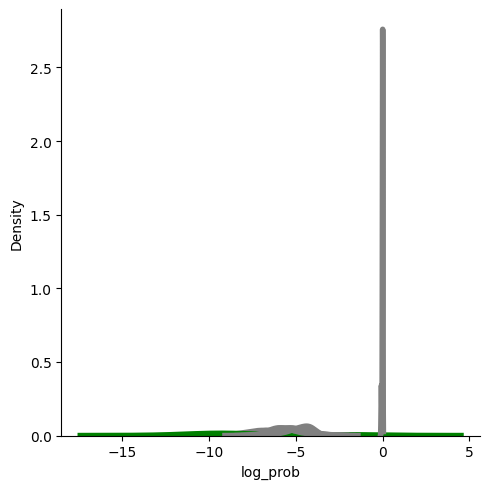

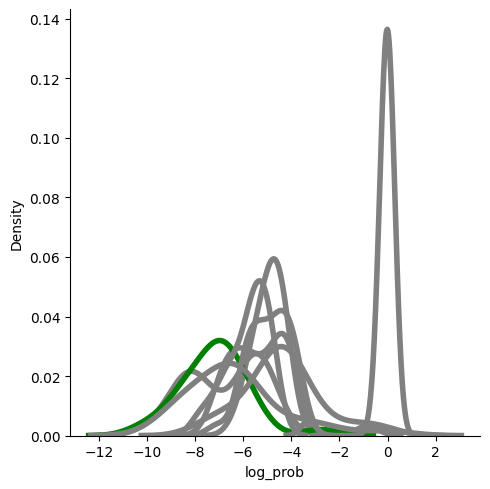

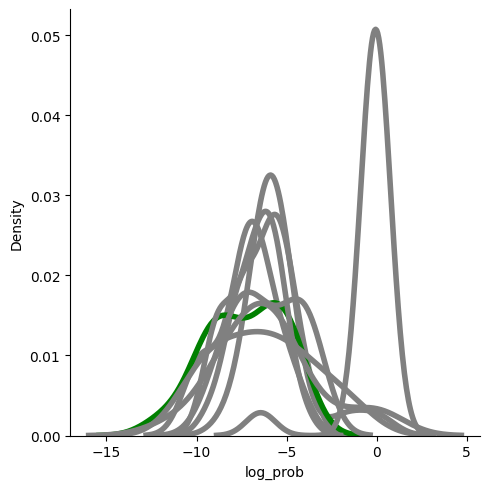

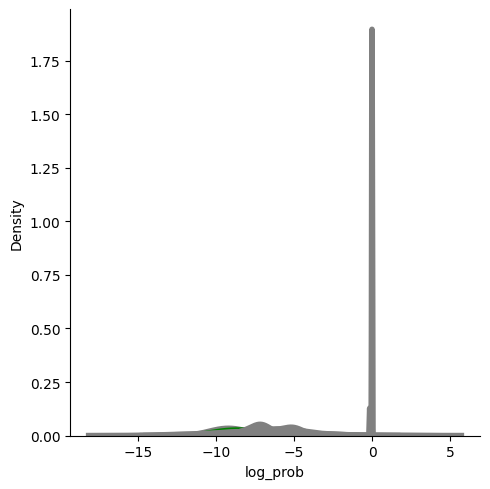

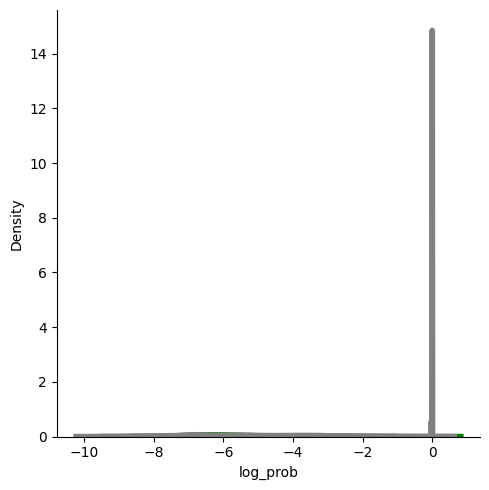

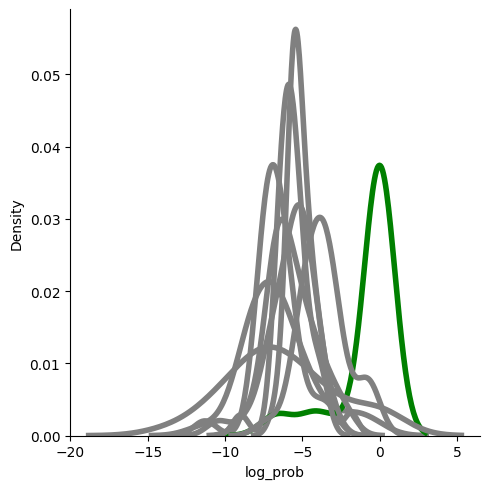

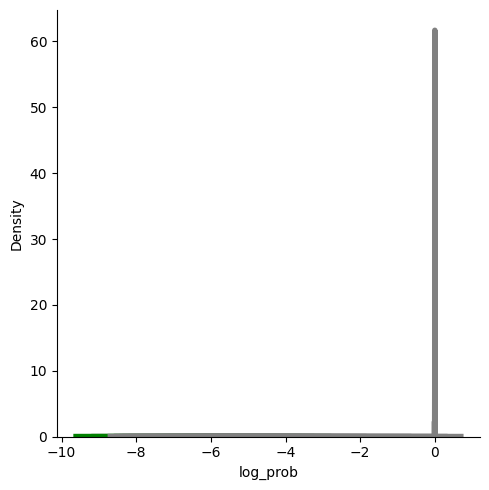

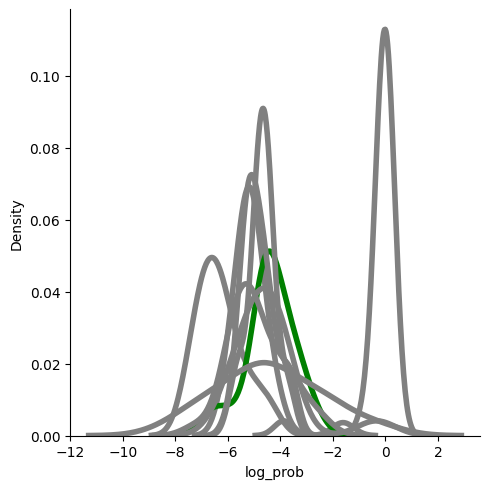

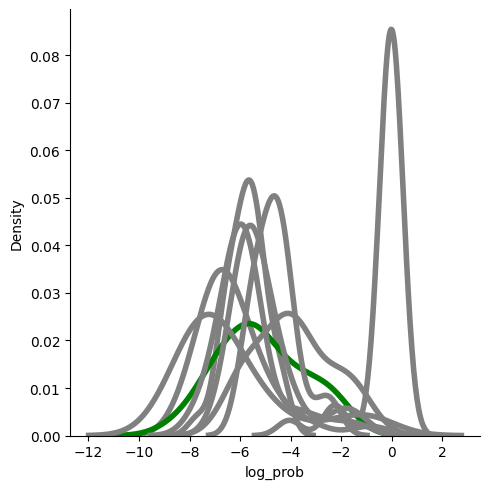

In [195]:
for col in scores_df.columns[:-4]:
    df2 = scores_df[scores_df["true-label"] == col]
    df2 = df2[df2.columns[:-4]]
    # print (df2)
    df2 = df2.stack().reset_index()

    df2.columns = ("index", "label", "log_prob")
    # print(df2)

    colors = {c: "green" if c == "invoices" else "grey" for c in df2.label.unique()}
    sns.displot(df2, x="log_prob", hue="label", kind="kde", palette=colors, legend=False, log_scale=False, linewidth=4)
    # plt.title(col)

In [3]:
## Import training data names table.
training_names_full = pd.read_csv(
    os.path.join(training_table_path, training_table_name), delimiter=" ", names=["directory", "doc type"], dtype=str
)

## Import validating data names table.
validating_names_full = pd.read_csv(
    os.path.join(validating_table_path, validating_table_name),
    delimiter=",",
    dtype=str,
)
validating_names_full = validating_names_full.filter(["file_path", "label"], axis=1)

print("The dimensions of the training table is:", training_names_full.shape)
print("The dimensions of the validating table is:", validating_names_full.shape)

print("Training head:")
print(training_names_full[:5])
print("Validating head:")
print(validating_names_full[:5])

The dimensions of the training table is: (12360, 2)
The dimensions of the validating table is: (250, 2)
Training head:
                                           directory doc type
0  /data/dssg/occrp/data/processed/receipts/Baham...        0
1  /data/dssg/occrp/data/processed/gazettes/Cayma...        2
2  /data/dssg/occrp/data/processed/receipts/Baham...        0
3  /data/dssg/occrp/data/processed/company-regist...        0
4  /data/dssg/occrp/data/processed/receipts/Baham...        0
Validating head:
                                           file_path      label
0  /data/dssg/occrp/data/aleph-exploration/output...  corrupted
1  /data/dssg/occrp/data/aleph-exploration/output...  corrupted
2  /data/dssg/occrp/data/aleph-exploration/output...  corrupted
3  /data/dssg/occrp/data/aleph-exploration/output...  corrupted
4  /data/dssg/occrp/data/aleph-exploration/output...  corrupted


In [4]:
## Importing labels:
labels_code = pd.read_csv(
    os.path.join(training_table_path, "labels.csv"),
    delimiter=",",
)
print("Encoded labels table:")
print(labels_code)

Encoded labels table:
             label  index
0            other      0
1  court-documents      1
2         gazettes      2


In [5]:
## Select 5 images of each class:
validating_names_full.rename(columns={"file_path": "directory", "label": "doc type"}, inplace=True)

validating_names_courtdocs = validating_names_full[validating_names_full["doc type"] == "court document"]
print("Number of court documents in our validating sample: ", validating_names_courtdocs.shape[0])
validating_names_gazette = validating_names_full[validating_names_full["doc type"] == "gazette"]
print("Number of gazettes in our validating sample: ", validating_names_gazette.shape[0])

validating_names_courtdocs_red = validating_names_courtdocs[:6]
validating_names_gazette_red = validating_names_gazette[:6]

print("We choose ", validating_names_courtdocs_red.shape[0], " court documents from our validating sample.")
print("We choose ", validating_names_gazette_red.shape[0], " gazettes from our validating sample. ")

Number of court documents in our validating sample:  7
Number of gazettes in our validating sample:  30
We choose  6  court documents from our validating sample.
We choose  6  gazettes from our validating sample. 


In [6]:
pd.options.display.max_colwidth = 200
display(validating_names_gazette)

directory  \
139   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/2533088.585d0bd4291ab027959e6412712377b2d8b465b4.pdf   
140   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/2542057.02fd5315fc8df894065505321717c184cbedd9a2.pdf   
141   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/2542058.6eeb4289e19a2e165710d7c61bec6cd30c1369e0.pdf   
142   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/2542064.a19ab894ddb0f5e6cb11e5e2d47bf417c5389463.pdf   
160   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/3378610.61b39a0d2205b3d8c6b283411f48691417f54abb.pdf   
162   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/4144240.896422d53e297ed401b48af1f1680cdba0390952.pdf   
163   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/4146811.2b31bac1be11e7c6a2c00b01d028f71231f0c577.pdf   
205   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/4683154.d6379004df6408150a5779dad9b88a3c654ca381.pdf   
206   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/4683335.bafddc36713760d800db062fb403e711b3ff6d0a.pdf   
214   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/5383344.c4c9851339460aa7aae4c464542d2063dcf8be4f.pdf   
223   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/5864317.478ad3d40c2fef84ee5480fa361835518ab9fd37.pdf   
224   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/5864427.1eb4789470efdb06ad7e1cb429dab84570defb5e.pdf   
226   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/6707481.404a0cf4da1b97ba75b9be8a0f37505e945c6ce4.pdf   
227   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/6755095.054f5d1d6c2df05edf939b23e76765f04c45765c.pdf   
228   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/6983013.b3b852dd2b48a4aebc94a3293d2b43f006aa697e.pdf   
229   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/6983126.799596322202b21b517da5a434c990502c143889.pdf   
230   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/6983185.50664310c2d7906b1c1338f6eeec8ded544e0ab9.pdf   
231  /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/72748503.347e14e06b957171edcfd93dd43e634fd9e2c9ae.pdf   
232  /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/72751706.4b6f7a3a190451fcd2ea25306b83c419fc986c18.pdf   
233  /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/72751712.7e5686d8157f604d13893f557d769151984471cc.pdf   
234  /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/72751735.5385d50a850250a6a5402042476117719cd3b87f.pdf   
235  /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/72751763.c727a639447b7e42a6fb2641a3ddaf0ae48538bb.pdf   
236  /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/72751765.ce5eb8c020a7adc79996370927f29ced5975fd75.pdf   
237   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/8027890.59036fc88b1b9cf1ead7d7bf80ed2e519105b641.pdf   
238   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/8027956.dc138c472bdd87af6b73b30605d80e873987214b.pdf   
239   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/8271295.d7b344435399a08c0e89cfd29b3745ff0ff21990.pdf   
240   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/8271354.125f2aa17819e0ffe41d8cc0627ddeef33503523.pdf   
247   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/8535420.db7157571a9230a9610611287f709cecdfb71904.pdf   
248   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/8536396.06337e448d36ad1eff5bd4a9993445800d7f90a9.pdf   
249   /data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/8536617.449952e71edc848b15c05621783e27dddf6d1b90.pdf   

    doc type  
139  gazette  
140  gazette  
141  gazette  
142  gazette  
160  gazette  
162  gazette  
163  gazett

In [7]:
## Select 5 images of each class:
training_names_courtdocs = training_names_full[training_names_full["doc type"] == "1"]
print("Number of court documents in our training sample: ", training_names_courtdocs.shape[0])
training_names_gazette = training_names_full[training_names_full["doc type"] == "2"]
print("Number of gazettes in our training sample: ", training_names_gazette.shape[0])

training_names_courtdocs_red = training_names_courtdocs[:6]
training_names_gazette_red = training_names_gazette[:6]

print("We choose ", training_names_courtdocs_red.shape[0], " court documents from our training sample.")
print("We choose ", training_names_gazette_red.shape[0], " gazettes from our training sample. ")

Number of court documents in our training sample:  1563
Number of gazettes in our training sample:  3163
We choose  6  court documents from our training sample.
We choose  6  gazettes from our training sample. 


In [8]:
## Reseting index:
training_names_courtdocs_red = training_names_courtdocs_red.reset_index()
training_names_gazette_red = training_names_gazette_red.reset_index()
validating_names_courtdocs_red = validating_names_courtdocs_red.reset_index()
validating_names_gazette_red = validating_names_gazette_red.reset_index()

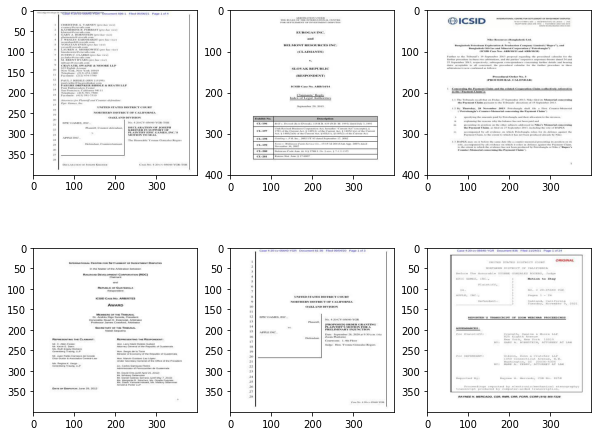

In [9]:
figure, axis = plt.subplots(2, 3)

for index in range(6):
    img = mpimg.imread(training_names_courtdocs_red["directory"][index])
    cv2.imwrite(os.path.join(save_output_images_path, "train_court" + str(index) + ".png"), img)

    x_ = index % 2
    y_ = index % 3

    axis[x_, y_].imshow(img)

figure.set_figwidth(10)
figure.set_figheight(8)

# Combine all the operations and display
plt.show()

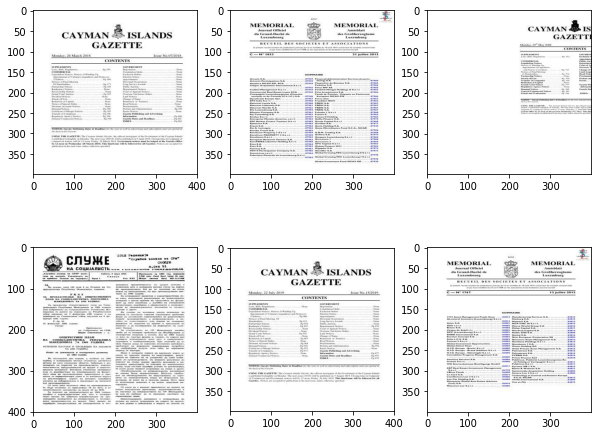

In [10]:
figure, axis = plt.subplots(2, 3)

for index in range(6):
    img = mpimg.imread(training_names_gazette_red["directory"][index])
    cv2.imwrite(os.path.join(save_output_images_path, "train_gazette" + str(index) + ".png"), img)

    x_ = index % 2
    y_ = index % 3

    axis[x_, y_].imshow(img)

figure.set_figwidth(10)
figure.set_figheight(8)

# Combine all the operations and display
plt.show()

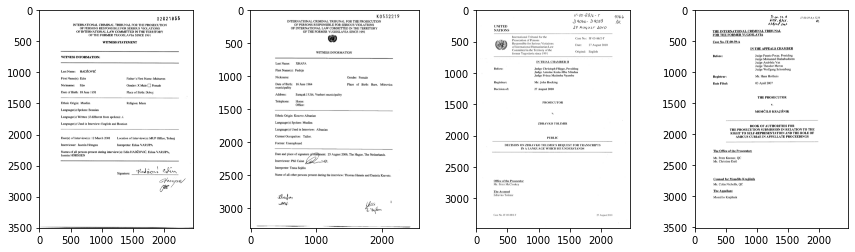

In [11]:
figure, axis = plt.subplots(1, 4)

for index in range(4):
    img = mpimg.imread(validating_names_courtdocs_red["directory"][index])
    cv2.imwrite(os.path.join(save_output_images_path, "val_court" + str(index) + ".png"), img)

    x_ = index % 2
    y_ = index % 2

    axis[index].imshow(img)

figure.set_figwidth(15)
figure.set_figheight(4)

# Combine all the operations and display
plt.show()

# imgplot = plt.imshow(img)

In [12]:
## Saving these tables for future reference:
training_names_courtdocs_red.to_csv(os.path.join(save_input_images_path, "training_courtdocs.csv"), sep=",")
training_names_gazette_red.to_csv(os.path.join(save_input_images_path, "training_gazettes.csv"), sep=",")
validating_names_courtdocs_red.to_csv(os.path.join(save_input_images_path, "validating_courtdocs.csv"), sep=",")
validating_names_gazette_red.to_csv(os.path.join(save_input_images_path, "validating_gazettes.csv"), sep=",")

In [13]:
train_court_images, train_court_labels, faulty = import_images(
    images_dir="", names=training_names_courtdocs_red, im_size=im_size, verbose=False
)
train_gazette_images, train_gazette_labels, faulty = import_images(
    images_dir="", names=training_names_gazette_red, im_size=im_size, verbose=False
)

val_court_images, val_court_labels, faulty = import_images(
    images_dir="", names=validating_names_courtdocs_red, im_size=im_size, verbose=False
)
# val_gazette, labels, faulty = import_images(images_dir = "", names = validating_names_gazette_red, im_size = im_size, verbose=False)

print(train_court_images.shape)
print(train_gazette_images.shape)
print(val_court_images.shape)
# print(val_gazette.shape)

(6, 227, 227, 3)
(6, 227, 227, 3)
(4, 227, 227, 3)


In [14]:
train_court_labels = [int(x) for x in train_court_labels]
train_court_labels = np.array(train_court_labels)
train_court_labels = train_court_labels.reshape(-1, 1)

train_gazette_labels = [int(x) for x in train_gazette_labels]
train_gazette_labels = np.array(train_gazette_labels)
train_gazette_labels = train_gazette_labels.reshape(-1, 1)

val_court_labels = [1, 1, 1, 1]
val_court_labels = np.array(val_court_labels)
val_court_labels = val_court_labels.reshape(-1, 1)

In [15]:
train_court_ds = tensorflow_format(train_court_images, train_court_labels, 5)
train_gazette_ds = tensorflow_format(train_gazette_images, train_gazette_labels, 5)
val_court_ds = tensorflow_format(val_court_images, val_court_labels, 4)

train_court_images_normalized = tf.image.per_image_standardization(train_court_images)
train_gazette_images_normalized = tf.image.per_image_standardization(train_gazette_images)
val_court_images_normalized = tf.image.per_image_standardization(val_court_images)

train_court_images_normalized = np.array(train_court_images_normalized)
train_gazette_images_normalized = np.array(train_gazette_images_normalized)
val_court_images_normalized = np.array(val_court_images_normalized)


# train_court_images_normalized = tf.data.Dataset.from_tensor_slices(train_court_images_normalized)

In [17]:
for index in range(6):
    # Instantiation of the explainer
    explainer = GradCAM()

    # Call to explain() method
    explain_train_court = explainer.explain(
        validation_data=(train_court_images_normalized[[index], ...], train_court_labels[[index]]),
        model=model,
        class_index=1,
        layer_name="conv2d_4",
    )
    # Save output
    explainer.save(
        explain_train_court, output_dir=save_output_images_path, output_name="explain_train_court" + str(index) + ".png"
    )

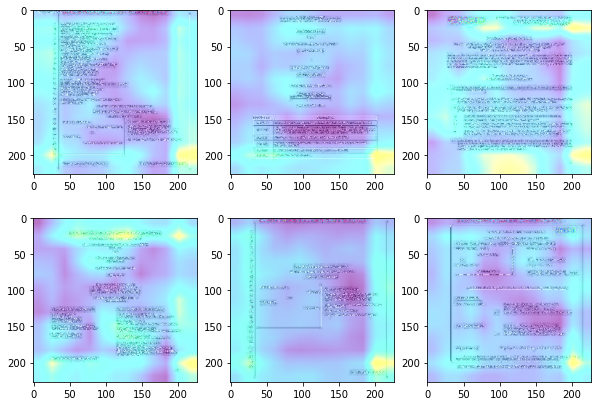

In [19]:
figure, axis = plt.subplots(2, 3)

for index in range(6):
    img = mpimg.imread(os.path.join(save_output_images_path, "explain_train_court" + str(index) + ".png"))
    x_ = index % 2
    y_ = index % 3

    axis[x_, y_].imshow(img)


figure.set_figwidth(10)
figure.set_figheight(7)

# Combine all the operations and display
plt.show()

# imgplot = plt.imshow(img)

In [21]:
for index in range(6):
    # Instantiation of the explainer
    explainer = GradCAM()

    # Call to explain() method
    explain_train_court = explainer.explain(
        validation_data=(train_gazette_images_normalized[[index], ...], train_gazette_labels[[index]]),
        model=model,
        class_index=2,
        layer_name="conv2d_4",
    )
    # Save output
    explainer.save(
        explain_train_court, output_dir=save_output_images_path, output_name="explain_train_gazette" + str(index) + ".png"
    )

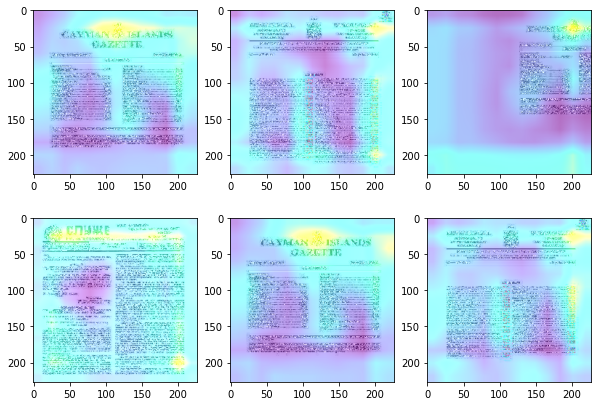

In [22]:
figure, axis = plt.subplots(2, 3)

for index in range(6):
    img = mpimg.imread(os.path.join(save_output_images_path, "explain_train_gazette" + str(index) + ".png"))
    x_ = index % 2
    y_ = index % 3

    axis[x_, y_].imshow(img)

figure.set_figwidth(10)
figure.set_figheight(7)

# Combine all the operations and display
plt.show()

# imgplot = plt.imshow(img)

In [24]:
for index in range(4):
    # Instantiation of the explainer
    explainer = GradCAM()

    # Call to explain() method
    explain_train_court = explainer.explain(
        validation_data=(val_court_images_normalized[[index], ...], val_court_labels[[index]]),
        model=model,
        class_index=2,
        layer_name="conv2d_4",
    )
    # Save output
    explainer.save(
        explain_train_court, output_dir=save_output_images_path, output_name="explain_val_court" + str(index) + ".png"
    )

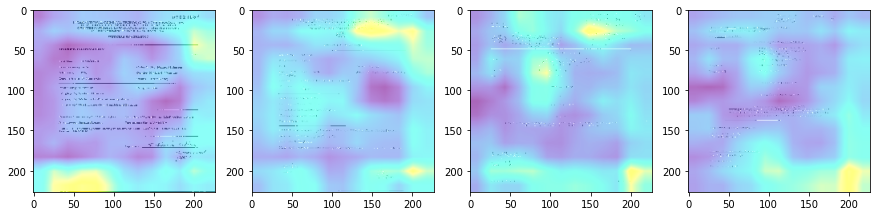

In [23]:
figure, axis = plt.subplots(1, 4)

for index in range(4):
    img = mpimg.imread(os.path.join(save_output_images_path, "explain_val_court" + str(index) + ".png"))
    axis[index].imshow(img)


figure.set_figwidth(15)
figure.set_figheight(4)

# Combine all the operations and display
plt.show()

# imgplot = plt.imshow(img)